In [1]:
import os
import torch
import mlflow
import gc
import time

from MED.modeling.modeling_utils import train_single_epoch, train_single_epoch_siamese, validate_single_epoch, validate_single_epoch_siamese, \
      retrieve_results_mlflow, create_summary_df, define_model_objects, save_model
from MED.dataset.dataset_utils import retrieve_dataloaders_window, compute_window_size_stride
from MED.visualization.utils import plot_results_LOSO, plot_cm

In [2]:
#def main(): #Main loop for training.
cuda = False
if cuda:
    torch.cuda.empty_cache() # Clear cache
    
else:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    torch.mps.empty_cache()

settings = ['LOSO']#, 'LOUO']
tasks = ['All', 'Suturing','Knot_Tying','Needle_Passing']
out1 = ['Bout','Cout','Dout','Eout','Fout','Gout','Hout','Iout']
out2 = ['1out', '2Out', '3out','4out','5out']

exp_kwargs = {
    'error_type': "global",
    'dataset_type': "window", #'window' or 'frame' 
    'save_local': False,
    'pos_weight': False, 
    'use_COG_video': True,
    'n_epochs': 15,
    'batch_size': 512,
    'frequency': 5,
    'lr': 5e-4,
    'lr_scheduler': True, 
    'weight_decay': 5e-3,
    'num_layers': 3,
    'hidden_size': 128,
    'model_name': 'SimpleCNN', #SimpleLSTM, SimpleCNN, Siamese_CNN, Siamese_LSTM 
    'siamese': False,
    'n_comparisons': 20,
    'n_pairs': 20000,
    'video_dims': 32, #32 default
    'loss_or_f1': 'f1',  #'loss' or 'f1' to determine the metric for validation
    'data_type': 'multimodal', #'multimodal' or 'video' or 'kinematics'
    'delete_ND': False,
    'return_train_preds': True, #True if we want to return train predictions and labels
    'compute_from_str': True
}

window_size, stride = compute_window_size_stride(exp_kwargs['frequency'])

best_model = None
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

#Set up folders to save results and images
results_folder = f"results/{exp_kwargs['data_type']}/{exp_kwargs['frequency']}Hz/{exp_kwargs['model_name']}/"
image_folder = f"images/{exp_kwargs['data_type']}/{exp_kwargs['frequency']}Hz/{exp_kwargs['model_name']}/" 

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

if not os.path.exists(image_folder):
    os.makedirs(image_folder)

#Define in_features
in_features_dict = {
    'multimodal': exp_kwargs['video_dims'] + 26,
    'video': exp_kwargs['video_dims'],
    'kinematics': 26
}

Loading data for LOSO with trial 1out...


/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)
/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)


Windowing data...
Creating datasets and dataloaders...
Number of training windows: 3174
Number of testing windows: 1078
Class distribution for LOSO with trial 1out: (tensor(0.4537), tensor(0.5463))
Class distribution for test set LOSO with trial 1out: (tensor(0.2941), tensor(0.7059))
Number of parameters to optimize: 1267329


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:03<00:00,  2.25it/s]


Epoch 1/15, F1: 0.8743, Loss: 0.3898, Accuracy: 0.8599


Test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:00<00:00,  4.40it/s]


New best F1 score: 0.7085377827091172 at epoch 1


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  5.34it/s]


Epoch 6/15, F1: 0.9985, Loss: 0.0561, Accuracy: 0.9983


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  5.23it/s]


Epoch 11/15, F1: 0.9977, Loss: 0.0417, Accuracy: 0.9978


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  5.21it/s]


Epoch 15/15, F1: 0.9997, Loss: 0.0377, Accuracy: 0.9997


Test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:00<00:00,  5.48it/s]


Inference rate: 0.8471 ms per window.


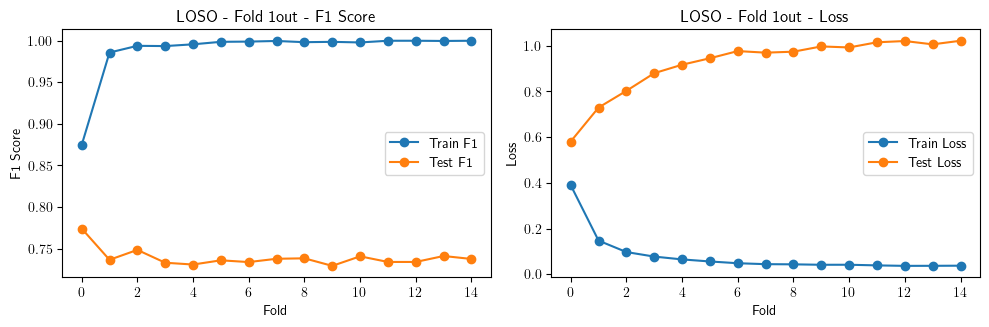

Model saved to models/multimodal/5Hz/SimpleCNN/best_model_LOSO_1out.pt
Loading data for LOSO with trial 2Out...


/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)
/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)


Windowing data...
Creating datasets and dataloaders...
Number of training windows: 3476
Number of testing windows: 776
Class distribution for LOSO with trial 2Out: (tensor(0.4194), tensor(0.5806))
Class distribution for test set LOSO with trial 2Out: (tensor(0.3853), tensor(0.6147))
Number of parameters to optimize: 1267329


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:02<00:00,  3.41it/s]


Epoch 1/15, F1: 0.8729, Loss: 0.3813, Accuracy: 0.8569


Test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00,  4.31it/s]


New best F1 score: 0.6508834783456411 at epoch 1


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  4.75it/s]


Epoch 6/15, F1: 0.9975, Loss: 0.0760, Accuracy: 0.9971


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  4.73it/s]


Epoch 11/15, F1: 0.9990, Loss: 0.0558, Accuracy: 0.9988


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  4.49it/s]


Epoch 15/15, F1: 0.9993, Loss: 0.0530, Accuracy: 0.9992


Test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00,  5.09it/s]


Inference rate: 1.4169 ms per window.


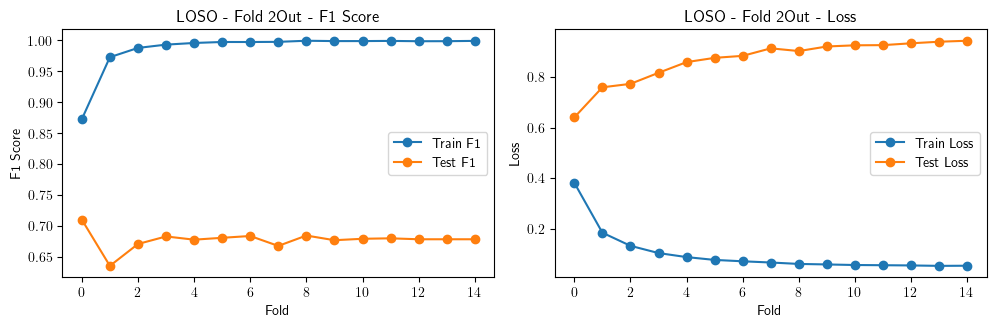

Model saved to models/multimodal/5Hz/SimpleCNN/best_model_LOSO_2Out.pt
Loading data for LOSO with trial 3out...


/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)
/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)


Windowing data...
Creating datasets and dataloaders...
Number of training windows: 3364
Number of testing windows: 888
Class distribution for LOSO with trial 3out: (tensor(0.4067), tensor(0.5933))
Class distribution for test set LOSO with trial 3out: (tensor(0.4381), tensor(0.5619))
Number of parameters to optimize: 1267329


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  3.61it/s]


Epoch 1/15, F1: 0.9082, Loss: 0.3177, Accuracy: 0.8956


Test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00,  3.86it/s]


New best F1 score: 0.6184375155361599 at epoch 1


Test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00,  4.46it/s]


New best F1 score: 0.6325032579749561 at epoch 2


Test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00,  4.38it/s]


New best F1 score: 0.6329523715623522 at epoch 3


Test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00,  4.48it/s]


New best F1 score: 0.6398417909526823 at epoch 4


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  4.91it/s]


Epoch 6/15, F1: 0.9981, Loss: 0.0656, Accuracy: 0.9978


Test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00,  4.47it/s]


New best F1 score: 0.6428381084028926 at epoch 9


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  4.89it/s]


Epoch 11/15, F1: 0.9998, Loss: 0.0484, Accuracy: 0.9997


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  4.87it/s]


Epoch 15/15, F1: 0.9991, Loss: 0.0474, Accuracy: 0.9990


Test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00,  4.40it/s]


New best F1 score: 0.6440414831293799 at epoch 15
Inference rate: 0.9990 ms per window.


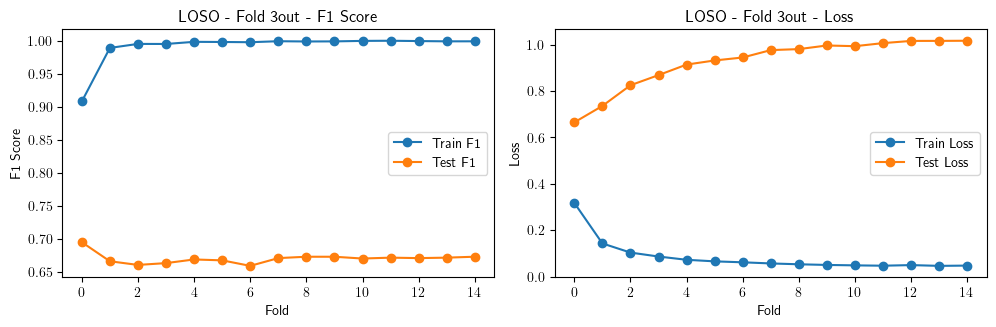

Model saved to models/multimodal/5Hz/SimpleCNN/best_model_LOSO_3out.pt
Loading data for LOSO with trial 4out...


/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)
/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)


Windowing data...
Creating datasets and dataloaders...
Number of training windows: 3382
Number of testing windows: 870
Class distribution for LOSO with trial 4out: (tensor(0.3950), tensor(0.6050))
Class distribution for test set LOSO with trial 4out: (tensor(0.4839), tensor(0.5161))
Number of parameters to optimize: 1267329


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  3.51it/s]


Epoch 1/15, F1: 0.9137, Loss: 0.3200, Accuracy: 0.8996


Test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00,  3.87it/s]


New best F1 score: 0.6747964723159285 at epoch 1


Test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00,  4.62it/s]


New best F1 score: 0.6792980578513846 at epoch 2


Test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00,  4.64it/s]


New best F1 score: 0.6825573988135564 at epoch 3


Test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00,  4.56it/s]


New best F1 score: 0.6861683404602649 at epoch 4


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  4.94it/s]


Epoch 6/15, F1: 0.9991, Loss: 0.0684, Accuracy: 0.9989


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  4.84it/s]


Epoch 11/15, F1: 0.9992, Loss: 0.0511, Accuracy: 0.9990


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  4.85it/s]


Epoch 15/15, F1: 0.9995, Loss: 0.0486, Accuracy: 0.9994


Test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00,  4.62it/s]


Inference rate: 0.9353 ms per window.


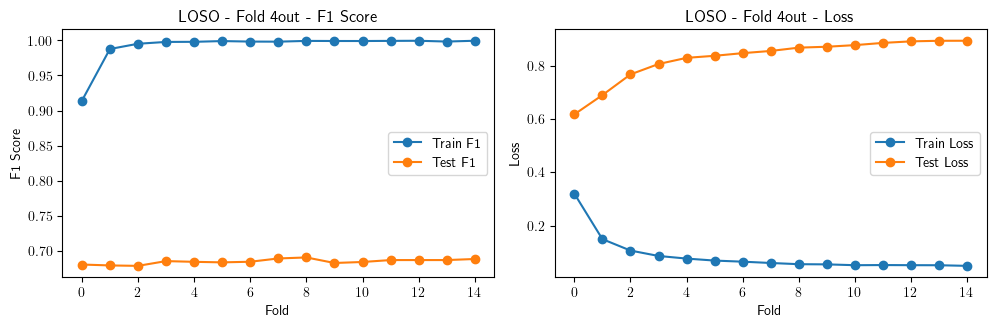

Model saved to models/multimodal/5Hz/SimpleCNN/best_model_LOSO_4out.pt
Loading data for LOSO with trial 5out...


/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)
/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)


Windowing data...
Creating datasets and dataloaders...
Number of training windows: 3612
Number of testing windows: 640
Class distribution for LOSO with trial 5out: (tensor(0.3948), tensor(0.6052))
Class distribution for test set LOSO with trial 5out: (tensor(0.5172), tensor(0.4828))
Number of parameters to optimize: 1267329


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8/8 [00:01<00:00,  4.77it/s]


Epoch 1/15, F1: 0.9254, Loss: 0.3014, Accuracy: 0.9155


Test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00,  4.91it/s]


New best F1 score: 0.682754419957958 at epoch 1


Test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00,  6.17it/s]


New best F1 score: 0.6985148140890878 at epoch 2


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8/8 [00:01<00:00,  5.29it/s]


Epoch 6/15, F1: 0.9982, Loss: 0.0674, Accuracy: 0.9978


Test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00,  6.19it/s]


New best F1 score: 0.7015457203639467 at epoch 7


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8/8 [00:01<00:00,  5.26it/s]


Epoch 11/15, F1: 0.9982, Loss: 0.0592, Accuracy: 0.9978


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8/8 [00:01<00:00,  5.34it/s]


Epoch 15/15, F1: 0.9996, Loss: 0.0521, Accuracy: 0.9995


Test: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00,  6.07it/s]


Inference rate: 0.9768 ms per window.


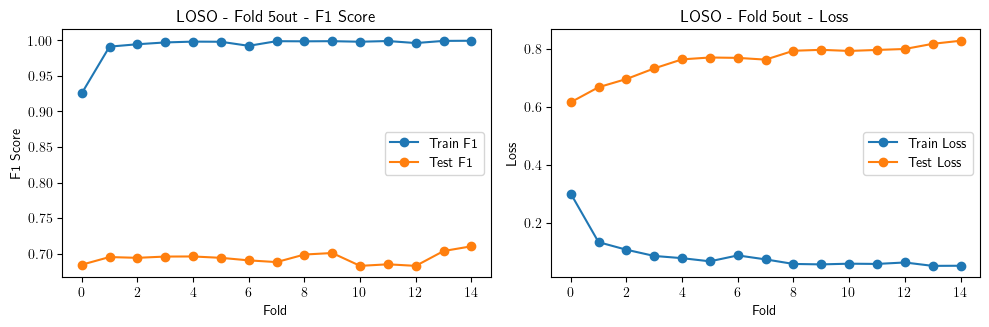

Model saved to models/multimodal/5Hz/SimpleCNN/best_model_LOSO_5out.pt
üèÉ View run whimsical-stoat-901 at: http://127.0.0.1:8080/#/experiments/604973780869113162/runs/d145207af75e4b55aacd218bed3b699a
üß™ View experiment at: http://127.0.0.1:8080/#/experiments/604973780869113162


In [3]:
mlflow.set_experiment(f"{exp_kwargs['model_name']}_{exp_kwargs['frequency']}Hz_{exp_kwargs['data_type']}")

#Ensure seed is set for reproducibility
torch.manual_seed(42)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)

samples_train, samples_test, inference_rates, train_times = [], [], [], []

with mlflow.start_run() as run:
    
    #Log the hyperparameters
    if not exp_kwargs['save_local']:
        mlflow.log_params(exp_kwargs)
        run_id = run.info.run_id

    for setting in settings:

        if setting == 'LOSO':
            outs = out2
        else:
            outs = out1

        for out in outs:

            #Delete device and RAM memory
            if cuda:
                torch.cuda.empty_cache()
            else:
                torch.mps.empty_cache()
                

            test_f1_fold, test_f1_weighted_fold, test_jaccard_fold, test_acc_fold, test_precision_fold, test_recall_fold, \
            test_fpr_fold, test_tpr_fold, test_class_report_fold, test_cm_fold, train_times_fold, \
            train_f1_fold, train_f1_weighted_fold, train_acc_fold, train_jaccard_fold, train_loss_fold, test_loss_fold = \
            ([] for _ in range(17))

            best_f1 = 0.0
            best_loss = float('inf')    
            save_best = False

            #a. Load training and testing data
            print(f"Loading data for {setting} with trial {out}...")
            fold_data_path = f"data/LOSO/{exp_kwargs['frequency']}Hz/" + out + '/'
            video_data_path = f"../Chain-of-Gesture/dataset/setting_f1/LOSO/All/{out}"
            #video_data_path = None
            
            #b. Retrieve dataloaders
            train_dataloader, test_dataloader = retrieve_dataloaders_window(fold_data_path=fold_data_path,
                                                                    video_data_path=video_data_path,
                                                                    exp_kwargs=exp_kwargs,
                                                                    window_size=window_size,
                                                                    stride=stride)
            
            samples_train.append(len(train_dataloader.dataset))
            samples_test.append(len(test_dataloader.dataset))
            
            #b.2. Compute class balance
            if not exp_kwargs['siamese']:
                class_counts = train_dataloader.dataset.binary_error_distribution
                class_counts_test = test_dataloader.dataset.binary_error_distribution
                print(f"Class distribution for {setting} with trial {out}: {class_counts}")
                print(f"Class distribution for test set {setting} with trial {out}: {class_counts_test}")

            #c. Define model objects
            feature_extractor, model, criterion, optimizer, scheduler = define_model_objects(exp_kwargs=exp_kwargs,
                                                                                             in_features_dict=in_features_dict,
                                                                                             window_size=window_size,
                                                                                             device=device,
                                                                                             class_counts=class_counts if not exp_kwargs['siamese'] else None)
            
            model_folder = f'models/{exp_kwargs["data_type"]}/{exp_kwargs["frequency"]}Hz/{model.name}/' 
            #d. Training loop
            for epoch in range(exp_kwargs['n_epochs']):
                train_start = time.time()
                if exp_kwargs['siamese']:
                    
                    train_loss, train_f1, train_f1_weighted, train_acc, train_auc_roc, train_jaccard, train_cm = train_single_epoch_siamese(model=model, 
                                                            feature_extractor=feature_extractor,
                                                            train_dataloader=train_dataloader,
                                                            criterion=criterion,
                                                            optimizer=optimizer,
                                                            device=device,
                                                            exp_kwargs=exp_kwargs,
                                                            scheduler=scheduler)
                    
                
                else:

                    if exp_kwargs['return_train_preds']:
                        train_loss, train_f1, train_f1_weighted, train_acc, train_jaccard, train_cm, \
                            train_all_probs, train_all_preds, train_all_labels, train_all_subjects = train_single_epoch(model=model,
                                                                                                    feature_extractor=feature_extractor,
                                                                                                    train_dataloader=train_dataloader,
                                                                                                    criterion=criterion,
                                                                                                    optimizer=optimizer,
                                                                                                    device=device,
                                                                                                    exp_kwargs=exp_kwargs,
                                                                                                    scheduler=scheduler)
                        
    
                    else:
                        train_loss, train_f1, train_f1_weighted, train_acc, train_jaccard, train_cm = train_single_epoch(model=model, 
                                                            feature_extractor=feature_extractor,
                                                            train_dataloader=train_dataloader,
                                                            criterion=criterion,
                                                            optimizer=optimizer,
                                                            device=device,
                                                            exp_kwargs=exp_kwargs,
                                                            scheduler=scheduler)
                    
                train_end = time.time()
                train_times_fold.append(train_end - train_start)

                if epoch % 5 == 0 or epoch == exp_kwargs['n_epochs'] - 1:
                    print(f"Epoch {epoch + 1}/{exp_kwargs['n_epochs']}, F1: {train_f1:.4f}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

                #Append to vectors
                train_f1_fold.append(train_f1)
                train_f1_weighted_fold.append(train_f1_weighted)
                train_loss_fold.append(train_loss)
                train_acc_fold.append(train_acc)
                train_jaccard_fold.append(train_jaccard)

                #Validation loop
                if exp_kwargs['siamese']:
                    test_loss, test_f1, test_f1_weighted, test_acc, test_auc_roc, test_jaccard, test_cm, inference_rate = validate_single_epoch_siamese(model=model,
                                                            feature_extractor=feature_extractor,
                                                            test_dataloader=test_dataloader,
                                                            criterion=criterion,
                                                            device=device,
                                                            exp_kwargs=exp_kwargs)

                else:
                    test_loss, test_f1, test_f1_weighted, test_acc, test_jaccard, test_cm, inference_rate, \
                        test_all_preds, test_all_probs, test_all_labels, test_all_labels_specific, test_all_gest_labels, test_all_subjects = validate_single_epoch(model=model,
                                                            feature_extractor=feature_extractor,
                                                            test_dataloader=test_dataloader,
                                                            criterion=criterion,
                                                            device=device,
                                                            exp_kwargs=exp_kwargs)
                
                #Append to vectors
                test_f1_fold.append(test_f1)
                test_f1_weighted_fold.append(test_f1_weighted)
                test_acc_fold.append(test_acc)
                test_jaccard_fold.append(test_jaccard)
                test_loss_fold.append(test_loss)
                

                if exp_kwargs['loss_or_f1'] == 'loss':
                    if test_loss < best_loss:
                        save_best = True
                        best_loss = test_loss
                        print(f"New best loss: {test_loss} at epoch {epoch + 1}")

                elif exp_kwargs['loss_or_f1'] == 'f1':
                    if test_f1_weighted > best_f1:
                        save_best = True
                        best_f1 = test_f1_weighted
                        print(f"New best F1 score: {test_f1_weighted} at epoch {epoch + 1}")

                if save_best:
                    
                    if exp_kwargs['return_train_preds']:

                        best_model = {
                            'feature_extractor': feature_extractor,
                            'model': model,
                            'epoch': epoch + 1,
                            'train_f1_fold': train_f1,
                            'test_f1_fold': test_f1,
                            'train_acc_fold': train_acc,
                            'test_acc_fold': test_acc,
                            'train_jaccard_fold': train_jaccard,
                            'test_jaccard_fold': test_jaccard,
                            'train_cm_fold': train_cm.tolist(),
                            'test_cm_fold': test_cm.tolist(), 
                            'train_all_labels': train_all_labels,
                            'test_all_labels': test_all_labels, 
                            'test_all_labels_specific': test_all_labels_specific,
                            'train_all_preds': train_all_preds,
                            'train_all_probs': train_all_probs,
                            'train_all_subjects': train_all_subjects,
                            'test_all_preds': test_all_preds,
                            'test_all_probs': test_all_probs,
                            'test_all_gest_labels': test_all_gest_labels,
                            'test_all_subjects': test_all_subjects,
                        }
                    
                    else:
                        best_model = {
                            'feature_extractor': feature_extractor,
                            'model': model,
                            'epoch': epoch + 1,
                            'train_f1_fold': train_f1,
                            'test_f1_fold': test_f1,
                            'train_acc_fold': train_acc,
                            'test_acc_fold': test_acc,
                            'train_jaccard_fold': train_jaccard,
                            'test_jaccard_fold': test_jaccard,
                            'train_cm_fold': train_cm.tolist(),
                            'test_cm_fold': test_cm.tolist(), 
                            'test_all_labels': test_all_labels, 
                            'test_all_labels_specific': test_all_labels_specific,
                            'test_all_preds': test_all_preds,
                            'test_all_probs': test_all_probs,
                            'test_all_gest_labels': test_all_gest_labels,
                            'test_all_subjects': test_all_subjects,
                        }

                    save_best = False  #Reset save_best to False after saving the best model
                
                if not exp_kwargs['save_local']:
                    #Log metrics to mlflow
                    mlflow.log_metric(f'train_loss_fold_{out}', train_loss, step=epoch)
                    mlflow.log_metric(f'test_loss_fold_{out}', test_loss, step=epoch)
                    mlflow.log_metric(f'train_f1_fold_{out}', train_f1, step=epoch)
                    mlflow.log_metric(f'test_f1_fold_{out}', test_f1, step=epoch)
                    mlflow.log_metric(f'train_acc_fold_{out}', train_acc, step=epoch)
                    mlflow.log_metric(f'test_acc_fold_{out}', test_acc, step=epoch)
                    mlflow.log_metric(f'train_jaccard_fold_{out}', train_jaccard, step=epoch)
                    mlflow.log_metric(f'test_jaccard_fold_{out}', test_jaccard, step=epoch)
                    
            #Display results for fold
            print(f"Inference rate: {inference_rate:.4f} ms per window.")
            plot_results_LOSO(train_f1_fold=train_f1_fold,
                            test_f1_fold=test_f1_fold,
                            train_loss_fold=train_loss_fold,
                            test_loss_fold=test_loss_fold,
                            setting=setting, out=out,
                            image_folder=image_folder)
            
        
            #Save best model
            if exp_kwargs['save_local']:
                pass   
                        
            else:
                #Log model to mlflow
                #if exp_kwargs['data_type'] != 'kinematics':
                    
                    #mlflow.pytorch.log_model(pytorch_model=best_model['feature_extractor'], 
                        #                    name=f'feature_extractor_{setting}_{out}')
                                
                #mlflow.pytorch.log_model(pytorch_model=best_model['model'], 
                      #                  name=f'model_{setting}_{out}')        
                      # 

                #Save model locally because mlflow gives errors
                if exp_kwargs['data_type'] != 'kinematics':
                    best_model['feature_extractor'] = best_model['feature_extractor'].state_dict()  
                    best_model['model'] = best_model['model'].state_dict()

                else:
                    best_model['feature_extractor'] = None
                    best_model['model'] = best_model['model'].state_dict()
                
                if not os.path.exists(model_folder):    
                    os.makedirs(model_folder)

                model_path = os.path.join(model_folder, f'best_model_{setting}_{out}.pt')   
                save_model(best_model=best_model, model_path=model_path)

                #Log best_model rest of the dictionary without the state dicts
                best_model_dict = best_model.copy()
                best_model_dict.pop('feature_extractor', None)
                best_model_dict.pop('model', None)
                mlflow.log_dict(best_model_dict, f'best_model_{setting}_{out}.json')

            #Compute mean inference rate and train time; append to lists
            inference_rates.append(inference_rate)
            train_times.append(sum(train_times_fold) / len(train_times_fold))

            #Delete memory and variables
            del train_dataloader, test_dataloader, feature_extractor, model, best_model
            gc.collect()

mlflow.end_run()

F1       Accuracy        Jaccard   Train Time Inference Rate
Train  0.948 ¬± 0.060  0.942 ¬± 0.067  0.917 ¬± 0.095  1.49 ¬± 0.03            NaN
Test   0.711 ¬± 0.039  0.676 ¬± 0.025  0.553 ¬± 0.048          NaN    1.04 ¬± 0.20

Confusion Matrix for Train:
Confusion Matrix for Train:


<Figure size 1500x1500 with 0 Axes>

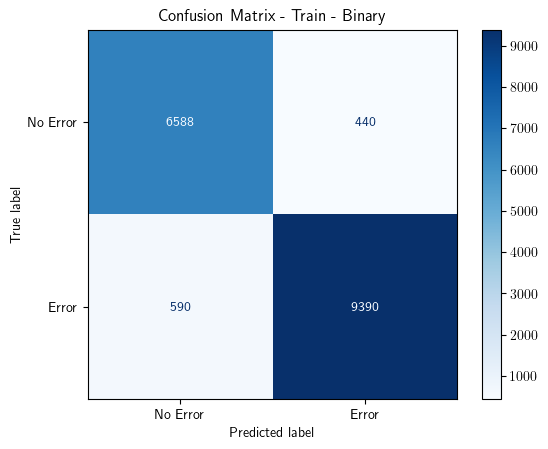

Confusion Matrix for Test:


<Figure size 1500x1500 with 0 Axes>

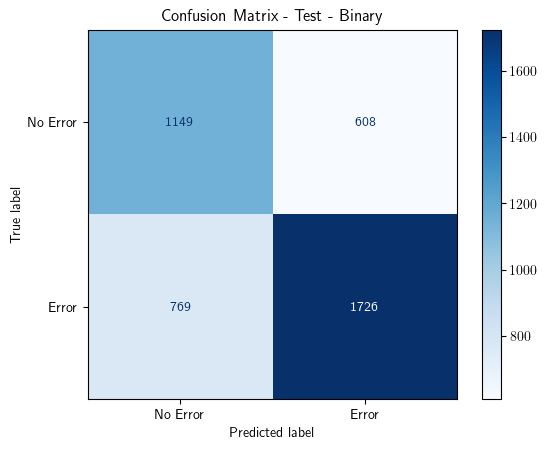

In [5]:
if exp_kwargs['return_train_preds']:
      LOSO_f1_train, LOSO_f1_test, LOSO_acc_train, LOSO_acc_test, LOSO_jaccard_train, LOSO_jaccard_test, \
    LOSO_cm_train, LOSO_cm_test, train_all_preds, train_all_probs, train_all_labels, train_all_subjects,\
    test_all_preds, test_all_probs, test_all_labels, test_all_labels_specific, test_all_gest_labels, test_all_subjects = retrieve_results_mlflow(outs=outs,
                                                                                                                                            exp_kwargs=exp_kwargs,
                                                                                                                                            setting=setting,
                                                                                                                                            run_id=run_id)
else:
    LOSO_f1_train, LOSO_f1_test, LOSO_acc_train, LOSO_acc_test, LOSO_jaccard_train, LOSO_jaccard_test, LOSO_cm_train, LOSO_cm_test = retrieve_results_mlflow(outs=outs,
                                                                                                                                                        exp_kwargs=exp_kwargs,
                                                                                                                                                        setting=setting,
                                                                                                                                                        run_id=run_id)
summary_df = create_summary_df(LOSO_f1_train=LOSO_f1_train, LOSO_f1_test=LOSO_f1_test, LOSO_acc_train=LOSO_acc_train,
                                LOSO_acc_test=LOSO_acc_test, LOSO_jaccard_train=LOSO_jaccard_train, LOSO_jaccard_test=LOSO_jaccard_test,
                                samples_train=samples_train, samples_test=samples_test,inference_rates=inference_rates, train_times=train_times)
#Save summary df to csv
display(summary_df)
summary_df.to_csv(os.path.join(results_folder, 'LOSO_summary_df.csv'), index=False)
    
print("Confusion Matrix for Train:")
plot_cm(LOSO_cm_train = LOSO_cm_train, LOSO_cm_test= LOSO_cm_test, image_folder=image_folder, binary = "Binary")